# **IEOR 4404  Simulation (Fall 2020)**

**Homework 3   [Total points: 80 Points]**


**Due 11:59 PM, Nov 1**

Homework 3 consists of application-oriented exercises focusing on different sampling techniques for a continuous distribution

The steps to finish the homework:

*   Step 1: Answer your homework on Google Colab.
*   Step 2: Submit the copy on Google Assignment

Before you submit your assignment, make sure to re-run your code from the beginning. (You can do so by first clicking Runtime/Reset All Runtimes and then clicking Runtime/Run all)



In [1]:
#Your Name: Yi-Ping Tseng
#Your UNI: yt2690

In [2]:
!pip install sympy -U

Requirement already up-to-date: sympy in /usr/local/lib/python3.6/dist-packages (1.6.2)


In [3]:
#This imports all the packages you need for the homework
#Please run this first
import numpy as np

import scipy.special as spsp

import matplotlib.pyplot as plt

%matplotlib inline


import scipy.stats as spst
 
import sympy
!pip install pynverse
import pynverse

import copy

import warnings
warnings.filterwarnings('ignore')

#Exercise 1 [25 Points]
##Setting

The three-point-estimate is commonly used in the industry for project management, risk management, etc. For example, team members can provide their optimistic ($A$), pessimistic ($B$), and best guess ($C$) estimates for their deliverables. A distribution will then be constructed based on those three values. 

The triangular distribution is a **continuous** distribution that follows a triangular shape. It is commonly used to construct the distribution following the three-point-estimate. 

For example, a team might be asked to give an estimation of the time it would take to finish the project. The team might come up with the pessimistic guess of 30 days, the optimistic guess of 10 days, and their best guess of 25 days. Then, a distribution of the number of days (treated as continuous) $x$ will be constructed as follows

$f(x)=
  \begin{cases}
    \frac{2(x-A)}{(B-A)(C-A)}, & \text{for } A \leq x < C \\
    \frac{2(B-x)}{(B-A)(B-C)}, & \text{for } C \leq x < B \\
    0, & \text{otherwise}
  \end{cases}
$


We will have $A<C<B$. In our case, $A$ will correspond to the optimistic value, $C$ will correspond to the best guess, and $B$ will correspond to the pessimistic value. 



## Q1. [5 points]
Plot the pdf of the number of days based on the information provided by the team. Choose 0 to 40 for the range of $x$ axis.

[`loop` and `if` statements are NOT allowed in your answer. When you want to use a loop or if condition, think about if you can use comparison operations to make your code efficient]

[You cannot use `scipy` package for this question]



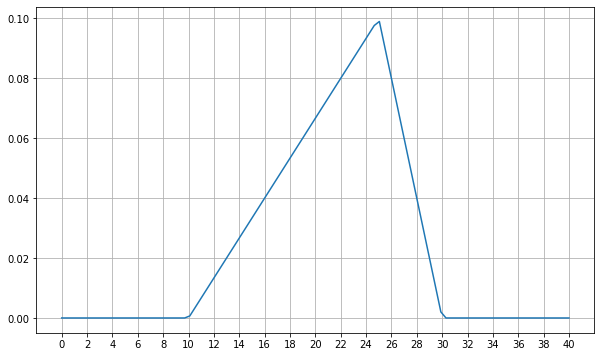

In [4]:
#Visualization

def triangular_pdf(x,A,B,C):
  mask_cond1 = (A <= x) & (x < C)
  mask_cond2 = (C <= x) & (x < B)
  pdf = np.zeros(len(x))
  pdf[mask_cond1] = 2*(x[mask_cond1] - A) / (B - A) / (C - A)
  pdf[mask_cond2] = 2*(B - x[mask_cond2])  / (B - A) / (B - C)
  return pdf

A = 10
B = 30 
C = 25
x = np.linspace(0, 40, 100)
tri_pdf = triangular_pdf(x, A, B, C)
plt.figure(figsize=(10, 6))
plt.grid()
plt.plot(x, tri_pdf)
plt.xticks(range(0, 41, 2))
plt.show()

## Q2. [15 points]

We can use the inverse transform method to directly sample from the target distribution. 

* Generate 10000 samples using the inverse transform method. Use `sympy` (Especially `simpy.lambdify()`) to show the derivation.  

* After generating the samples, plot the distribution of the samples.

Hint: When doing the inverse transform method, you should derive the formula for $(A,C)$ interval and $(C,B)$ interval separately. Think about what the CDF function is for $x$ in range $(A,C)$ and in range $(C,B)$. The same idea applies to the stage when you draw $u \sim Unif(0,1)$ and convert it to $x$ using the inverse CDF function.

[`loop` and `if` statements are NOT allowed in your answer. When you want to use a loop or if condition, think about if you can use comparison operations to make your code efficient]

[You cannot use `scipy` package for this question]

In [5]:
#show your derivation here
x = sympy.Symbol("x", nonnegative=True)
u = sympy.Symbol("u")
A = sympy.Symbol("A")
B = sympy.Symbol("B")
C = sympy.Symbol("C")
pdf_ac = 2*(x - A) / (B - A) / (C - A)
pdf_cb = 2*(B - x)  / (B - A) / (B - C)
cdf_ac = sympy.integrate(pdf_ac, (x, A, x))
cdf_cb = sympy.integrate(pdf_cb, (x, C, x)) + cdf_ac.subs({x: C})

In [6]:
inv_cdf_ac = sympy.solve(cdf_ac - u, x)[1]
inv_cdf_ac

A + sqrt(u*(A - B)*(A - C))

In [7]:
inv_cdf_cb = sympy.solve(cdf_cb - u, x)[0]
inv_cdf_cb

B - sqrt((A - B)*(B - C)*(u - 1))

In [8]:
inv_cdf_ac_lambda = sympy.lambdify((A, B, C, u), inv_cdf_ac, "numpy")
inv_cdf_cb_lambda = sympy.lambdify((A, B, C, u), inv_cdf_cb, "numpy")

sympy.N(cdf_ac.subs({x: 25, A: 10, B: 30, C: 25}).doit())

0.750000000000000

In [13]:
#define a function used to generate the samples using inverse method. 
#No loops should be used

def triangle_inverse(N, A, B, C, cdf_to_c):
  global inv_cdf_ac_lambda
  global inv_cdf_cb_lambda
  global cdf_ac
  
  u = np.random.rand(N)
  mask = u <= cdf_to_c
  samples = np.append(inv_cdf_ac_lambda(A, B, C, u[mask]), inv_cdf_cb_lambda(A, B, C, u[~mask]))
  return samples

#generate the samples 
A = 10
B = 30 
C = 25
N = 10000
samples = triangle_inverse(N, A, B, C, 0.75)

Text(0.5, 0, 'x')

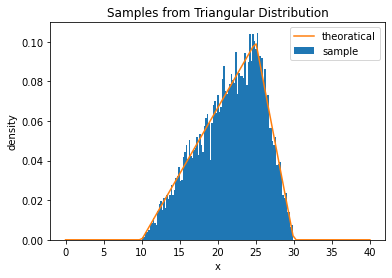

In [14]:
#visualize the distribution of samples 
plt.hist(samples, bins=int(N/100), density=True, label='sample')
x = np.linspace(0, 40, 100)
tri_pdf = triangular_pdf(x, A, B, C)
plt.plot(x, tri_pdf, label='theoratical')
plt.title('Samples from Triangular Distribution')
plt.legend()
plt.ylabel('density')
plt.xlabel('x')

## Q3. [5 points]

The team estimated that the profit that they will get from the project follows the following formula.

$Profit=18000-20 days^2$

* Plot the sample distribution of the profit based on 10000 samples.
* Based on the samples, give the probability of profit being lower than 5000.

[`loop` and `if` statements are NOT allowed in your answer. When you want to use a loop or if condition, think about if you can use comparison operations to make your code efficient]

[You cannot use `scipy` package for this question]

Text(0, 0.5, 'density')

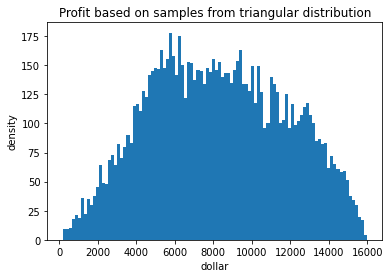

In [15]:
profit = 18000 - 20 * samples**2
plt.hist(profit, bins=int(N/100))
plt.title('Profit based on samples from triangular distribution')
plt.xlabel('dollar')
plt.ylabel('density')

In [16]:
sum(profit<5000) / len(profit)

0.2017

#Exercise 2 [30 Points]
##Setting 

In this exercise, let's sample from a [truncated normal distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution) between $x_l$ and $x_u$.

A truncated normal distribution between $x_l$ and $x_u$ means $x$ should have followed a normal distribution if truncation did not happen. However, $x<x_l$ and $x>x_u$ will simply never appear or never be observed. As a result, the support of a truncated normal distribution is between $x_l$ and $x_u$.

The PDF of a truncated normal distribution follows:
$g(x|\mu,\sigma,x_l,x_u)=\begin{cases} \frac{f(x|\mu,\sigma)}{F(x_u|\mu,\sigma)-F(x_l|\mu,\sigma)} &\text{, if } x_l\leq x \leq x_u  \\ 0 & \text{,otherwise}\end{cases}$

Where, $f(x|\mu,\sigma)$ is the PDF of the original untruncated normal distribution, $F(x_l|\mu,\sigma)$ is the CDF of the original untruncated normal distribution evaluated at $x_l$, and $F(x_u|\mu,\sigma)$ is the CDF of the original normal distribution evaluated at $x_u$. To compute PDF and CDF of a normal distribution, you can use `scipy.stats.norm.pdf(x,loc,scale)`  and `scipy.stats.norm.cdf(x,loc,scale)`, where `loc` is the mean of the untruncated normal distribution, `scale` is the standard deviation of the untruncated normal distribution.

For this exercise, let's assume that $\mu=10$, $\sigma=3$, $x_l=8$, $x_u=12$ for all parts of the question.



## Q1. [10 Points]

* Visualize the pdf of a truncated normal distribution based on 1000 evenly spaced x values between 5 and 15.  
* In the same plot, plot the triangular distribution with $A=x_l$, $C=\mu$, $B=x_u$
* Is it a good idea to use the triangular distribution with $A=x_l$, $C=\mu$, $B=x_u$ as our proposal distribution? Explain based on visualizing the ratio between $pdf_t$ and $pdf_p$ and provide your reasoning.  


[`loop` and `if` statements are NOT allowed in your answer. When you want to use a loop or if condition, think about if you can use comparison operations to make your code efficient]

[You can only use `scipy` package to get pdf and cdf of a normal distribution]

In [28]:
x_l = 8
x_u = 12
mu = 10
sigma = 3
x = np.linspace(5, 15, 1000)
 
def trun_normal_pdf(x, mu, sigma, x_l, x_u):
  mask = (x_l <= x) & (x <= x_u)
  ans = copy.deepcopy(x)
  denom = spst.norm.cdf(x_u, mu, sigma) - spst.norm.cdf(x_l, mu, sigma)
  ans[mask] = spst.norm.pdf(x[mask], mu, sigma) / denom
  ans[~mask] = 0
  return ans

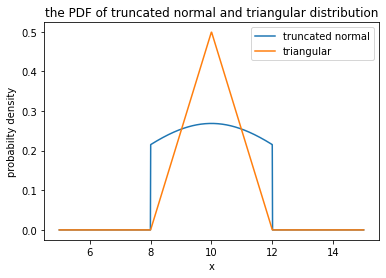

In [29]:
plt.plot(x, trun_normal_pdf(x, mu, sigma, x_l, x_u), label='truncated normal')
plt.plot(x, triangular_pdf(x, x_l, x_u, mu), label='triangular')
plt.title('the PDF of truncated normal and triangular distribution')
plt.xlabel('x')
plt.ylabel('probabilty density')
plt.legend()

'according to the plot, I will not use the triangular distribution with  𝐴=𝑥𝑙 ,  𝐶=𝜇 ,  𝐵=𝑥𝑢 as our proposal distribution since the ratio is nearly infinite around 𝑥𝑙 & 𝑥𝑢.'

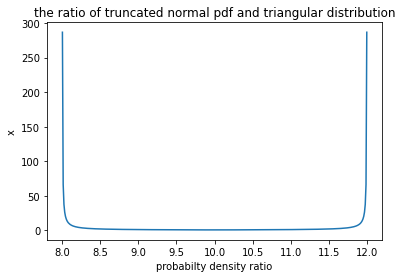

In [30]:
plt.plot(x, trun_normal_pdf(x, mu, sigma, x_l, x_u) / triangular_pdf(x, x_l, x_u, mu))
plt.title('the ratio of truncated normal pdf and triangular distribution')
plt.xlabel('probabilty density ratio')
plt.ylabel('x')

'''according to the plot, I will not use the triangular distribution with  𝐴=𝑥𝑙 ,  𝐶=𝜇 ,  𝐵=𝑥𝑢 as our proposal distribution since the ratio is nearly infinite around 𝑥𝑙 & 𝑥𝑢.'''

##Q2. [10 Point]
* Based on the numerical method, find out the set of $A$, $B$, and $C$ that gives the highest acceptance rate by searching different parameter values of the proposal distribution. [hint: since our target distribution is symmetric, you can also use a triangular distribution that is symmetric as your proposal distribution]
* In the same graph, plot both the pdf of truncated normal distribution and also the pdf of  triangular distribution with the optimal $A$, $B$, $C$ value you chose.

[`loop` and `if` statements are NOT allowed in your answer. When you want to use a loop or if condition, think about if you can use comparison operations to make your code efficient]

[You can only use `scipy` package to get pdf and cdf of a normal distribution]


In [31]:
#no need to explore A, B, C below 5 or above 15.
minC = float("inf")
best = 0
for i in np.linspace(1, 5, 1000):
  A = x_l - i
  B = x_u + i
  ratio = trun_normal_pdf(x, mu, sigma, x_l, x_u) / triangular_pdf(x, A, B, mu)
  ratio = np.nanmax(ratio[(ratio != np.inf) | (ratio != -np.inf)])
  # print(A, B, ratio)
  if ratio < minC:
    minC = ratio
    best = i

print('A: ', x_l - best)
print('B: ', x_u + best)
print('min c:', minC)

A:  6.007007007007007
B:  13.992992992992994
min c: 1.7194425321698767


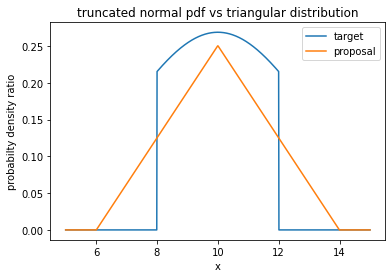

In [32]:
plt.plot(x, trun_normal_pdf(x, mu, sigma, x_l, x_u), label='target')
plt.plot(x, triangular_pdf(x, x_l - best, x_u + best, mu), label='proposal')
plt.title('truncated normal pdf vs triangular distribution')
plt.ylabel('probabilty density ratio')
plt.xlabel('x')
plt.legend()

##Q3. [10 points]

* Use rejection sampling to generate 10000 samples. When generating the samples use the parallel method. [That is, no loop or list comprehension is allowed]
* In the same graph, plot the sample distribution and the corresponding theoretical distribution.

[`loop` and `if` statements are NOT allowed in your answer. When you want to use a loop or if condition, think about if you can use comparison operations to make your code efficient]

[You can only use `scipy` package to get pdf and cdf of a normal distribution]


In [33]:
# calculate the inverse triangular distribution to create proposals

In [34]:
def tri_sample(N, c, mu=mu, sigma=sigma, x_l=x_l, x_u=x_u, best=best):
  numPoints = int(N*c + 4 * np.sqrt(N * (c**2 - c)))
  u = np.random.rand(numPoints)
  proposals = triangle_inverse(numPoints, x_l - best, x_u + best, mu, 0.5)
  
  AR = trun_normal_pdf(proposals, mu, sigma, x_l, x_u) / triangular_pdf(proposals, x_l - best, x_u + best, mu)/ c
  samples = proposals[u < AR]
  return samples[:N]

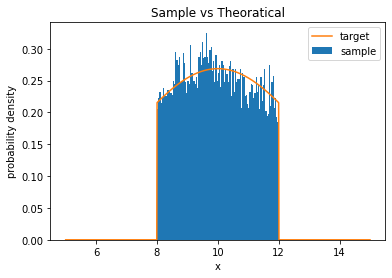

In [36]:
trunc_norm_samples = tri_sample(N, minC)
plt.hist(trunc_norm_samples, bins=int(N/100), density=True, label='sample')
plt.plot(x, trun_normal_pdf(x, mu, sigma, x_l, x_u), label='target')
plt.title('Sample vs Theoratical')
plt.xlabel('x')
plt.ylabel('probability density')
plt.legend()

#Exercise 3 [25 Points]

##Setting 
Beta distribution is a distribution with support between 0 and 1. It is very commonly used to model the distribution of probabilities. Its un-normalized PDF follows:

$f_u(x)=\begin{cases} x^{a-1}(1-x)^{b-1} & \text{if } 0 \leq x < 1 \\ 0 &  \text{otherwise} \end{cases}$

In this exercise, we will find a way to evaluate the expected value of a variable following this distribution without touching on the normalizing constant.

For this exercise, let's assume $a=2, b=3$.

## Q1. [6 Points]

* Plot $f_u(x)$ for x between 0 and 1.  
* Based on `sympy`, prove that this pdf is not normalized.

 

[You can not use `scipy` package for this question]



Text(0, 0.5, 'probability density')

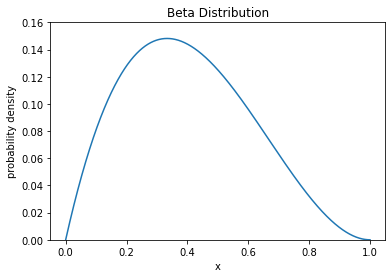

In [77]:
alpha = 2
beta = 3
x = np.linspace(0, 1, 1000)
pdf = x**(alpha - 1) * (1 - x)**(beta - 1)
plt.plot(x, pdf)
plt.ylim(0, 0.16)
plt.title('Beta Distribution')
plt.xlabel('x')
plt.ylabel('probability density')

In [127]:
alpha = sympy.Symbol("alpha")
beta = sympy.Symbol("beta")
x = sympy.Symbol("x")
pdf = x**(alpha - 1) * (1 - x)**(beta - 1)
cdf = sympy.integrate(pdf.subs({alpha: 2, beta: 3}), (x, 0, 1)).doit()
cdf

1/12

##Q2. [12 Points]

Use a uniform distribution as the proposal distribution to perform rejection sampling that will help you generate one sample from the beta distribution. When doing the rejection sampling, use the unnormalized pdf defined in the setting for the beta distribution.
* Find out the unnormalized $c$ based on `sympy` using the analytical method. Make sure that both the first-order condition and the second-order condition are checked. [Additionally, you can also use visualization to further confirm your answer] 
* Construct a function that returns one sample.
* Construct a function that will return N samples by calling the function you constructed in the last step.  
* Generate the 10000 samples and plot the sample distribution.


[You can not use `scipy` package for this question]



In [130]:
#first order
x = sympy.Symbol("x")
pdf_uniform = 1
pdf_beta = x**(alpha - 1) * (1 - x)**(beta - 1)
fx = pdf_beta / pdf_uniform
order_1 = sympy.diff(fx.subs({alpha: 2, beta: 3}), x)
x_best = sympy.solve(order_1, x)
x_best

[1/3, 1]

In [131]:
#second order
order_2 = sympy.diff(fx.subs({alpha: 2, beta: 3}), x, x)
'''we should choose x_best = 1/2'''
order_2.subs({x: 1/3}).simplify(), order_2.subs({x: 1}).simplify()

(-2.00000000000000, 2)

In [132]:
c = fx.subs({alpha: 2, beta:3, x: 1/3})
c

0.148148148148148

Text(0, 0.5, 'probability density ratio')

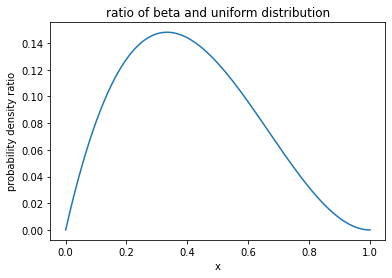

In [133]:
x = np.linspace(0, 1.001, 1000)
plt.plot(x, x**(2 - 1) * (1 - x)**(3 - 1) / 1)
plt.title('ratio of beta and uniform distribution')
plt.xlabel('x')
plt.ylabel('probability density ratio')

In [161]:
def rejection(c, alpha, beta):
  prop = np.random.rand()
  while np.random.rand() > (prop**(alpha - 1) * (1 - prop)**(beta - 1) / c):
    prop = np.random.rand()
  return  prop

def rejectionN(N, c, alpha, beta):
  return [rejection(c, alpha, beta) for _ in range(N)]

Text(0.5, 1.0, 'Sample Beta Distribution')

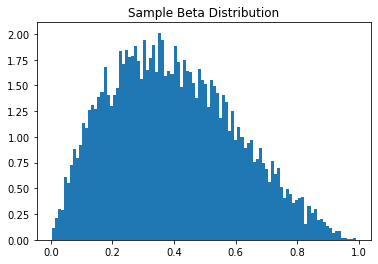

In [168]:
c = 0.148148148148148
samples = rejectionN(10000, c, 2, 3)
plt.hist(samples, bins=100, label='samples', density=True)
plt.title('Sample Beta Distribution')

##Q3. [7 Points]

The expected value of a variable following a beta distribution is $\frac{a}{a+b}$.

In the graph, demonstrate how the sample mean estimation will approach the expected value when we increase the sample size. [use sample size 1,2,3, $\dots$, 200]

To place a horizontal line to the plot, us [`plt.hlines()`](https://matplotlib.org/3.3.2/api/_as_gen/matplotlib.pyplot.hlines.html)

[You can not use `scipy` package for this question]


Text(0, 0.5, 'sample mean')

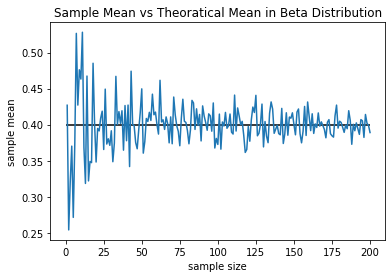

In [178]:
sample_mean = [np.mean(rejectionN(i, c, 2, 3)) for i in range(1, 201)]
plt.plot(range(1, 201), sample_mean, label='sample mean')
plt.hlines(2/(2+3), 0, 200, label='theoratical mean')
plt.title('Sample Mean vs Theoratical Mean in Beta Distribution')
plt.xlabel('sample size')
plt.ylabel('sample mean')